In [1]:
#Import common dependencies
import torch
import pandas as pd
import numpy as np
import matplotlib, matplotlib.pyplot as plt
from PIL import Image 
from skimage import io
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import random
import os
from sklearn.metrics import roc_auc_score
import copy
from timm.models.layers import trunc_normal_
from SwinTransformer.models.swin_transformer_v2 import SwinTransformerV2
from SwinTransformer.utils import get_grad_norm

[Warning] Fused window process have not been installed. Please refer to get_started.md for installation.
Tutel has not been installed. To use Swin-MoE, please install Tutel; otherwise, just ignore this.


In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
    
def setup_seed(seed): 
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed) 
    random.seed(seed) 
    torch.backends.cudnn.deterministic = True
    return None
setup_seed(0)

In [3]:
train_transform = transforms.Compose([])
train_transform.transforms.append(transforms.Pad((0,120), padding_mode='constant'))
train_transform.transforms.append(transforms.RandomHorizontalFlip())
train_transform.transforms.append(transforms.RandomVerticalFlip())
train_transform.transforms.append(transforms.RandomResizedCrop(384, scale=(0.5, 1.1), ratio=(1.0,1.0)))
train_transform.transforms.append(transforms.ToTensor())
train_transform.transforms.append(transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))

test_transform = transforms.Compose([])
test_transform.transforms.append(transforms.Pad((0,120), padding_mode='constant'))
test_transform.transforms.append(transforms.RandomResizedCrop(384, scale=(1.0, 1.0), ratio=(1.0,1.0)))
test_transform.transforms.append(transforms.ToTensor())
test_transform.transforms.append(transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]))

In [4]:
class hist_dataset(Dataset):
    def __init__(self, df_path, train = False):
        self.df = pd.read_csv(df_path)
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        image_path = self.df.iloc[idx]['FilePath']
        image = Image.open(image_path)
        
        if self.train:
            image_tensor = train_transform(image)
        else:
            image_tensor = test_transform(image)
            

        label = self.df.loc[idx]['Label']
        label = torch.tensor(label, dtype=torch.long)
        
        return image_tensor, label

In [5]:
train_df_path = '/home/zhang409/WorkSpace/BreakHis/Metadata/400x/unbalanced_test_set/train.csv'
val_df_path = '/home/zhang409/WorkSpace/BreakHis/Metadata/400x/unbalanced_test_set/val.csv'
test_df_path = '/home/zhang409/WorkSpace/BreakHis/Metadata/400x/unbalanced_test_set/test.csv'
BS = 1
num_workers = 8
train_loader = DataLoader(hist_dataset(train_df_path, train=False),\
                          batch_size=BS, num_workers=num_workers, pin_memory=True, shuffle=False)
val_loader = DataLoader(hist_dataset(val_df_path, train=False),\
                          batch_size=BS, num_workers=num_workers, pin_memory=True, shuffle=False)
test_loader = DataLoader(hist_dataset(test_df_path, train=False),\
                          batch_size=BS, num_workers=num_workers, pin_memory=True, shuffle=False)

In [6]:
sample = next(iter(test_loader))
sample_tensor = sample[0][0]

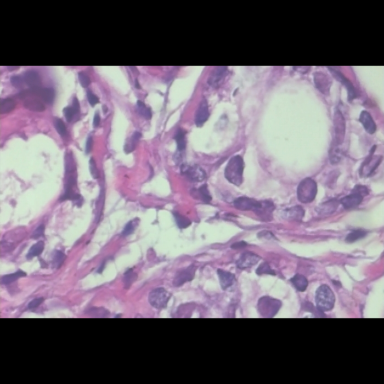

In [7]:
inv_normalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],\
                                     std=[1/0.229, 1/0.224, 1/0.225])
image = inv_normalize(sample_tensor)
transforms.ToPILImage()(image)

## Spervised Feature

In [8]:
model = SwinTransformerV2(img_size=384,
                          patch_size=4,
                          in_chans=3,
                          num_classes=1000,
                          embed_dim=128,
                          depths=[2, 2, 18, 2],
                          num_heads=[ 4, 8, 16, 32],
                          window_size=24,
                          mlp_ratio=4.,
                          qkv_bias=True,
                          drop_rate=0.0,
                          drop_path_rate=0.2,
                          ape=False,
                          patch_norm=True,
                          use_checkpoint=False,
                          pretrained_window_sizes=[ 12, 12, 12, 6 ])
model.head = nn.Linear(in_features=1024, out_features=2, bias=True)

weight = '/home/zhang409/WorkSpace/BreakHis/Test/Test_6_SwinTransformer/Swin_V2_B.pt'
model.load_state_dict(torch.load(weight)['best_model_wts'])
model.head = nn.Identity()

/home/zhang409/envs/DeepLearning/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
model = model.to(device)
model.eval()
Supervised_Fetures = []
Labels = []
with torch.no_grad():
    for i, (sample) in enumerate(test_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        Supervised_Fetures += outputs

In [10]:
print(len(Supervised_Fetures))
print(Supervised_Fetures[0].shape)

446
(1024,)


In [11]:
model = model.to(device)
model.eval()
Supervised_Fetures_train = []
Labels_train = []
with torch.no_grad():
    for i, (sample) in enumerate(train_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels_train += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        Supervised_Fetures_train += outputs

In [12]:
print(len(Supervised_Fetures_train))
print(Supervised_Fetures_train[0].shape)

1100
(1024,)


## ImageNet Pretrained Feature

In [13]:
model = SwinTransformerV2(img_size=384,
                          patch_size=4,
                          in_chans=3,
                          num_classes=1000,
                          embed_dim=128,
                          depths=[2, 2, 18, 2],
                          num_heads=[ 4, 8, 16, 32],
                          window_size=24,
                          mlp_ratio=4.,
                          qkv_bias=True,
                          drop_rate=0.0,
                          drop_path_rate=0.2,
                          ape=False,
                          patch_norm=True,
                          use_checkpoint=False,
                          pretrained_window_sizes=[ 12, 12, 12, 6 ])

weight = '/home/zhang409/WorkSpace/BreakHis/Test/Test_6_SwinTransformer/'+\
'swinv2_base_patch4_window12to24_192to384_22kto1k_ft.pth'
model.load_state_dict(torch.load(weight)['model'])
model.head = nn.Identity()

In [14]:
model = model.to(device)
model.eval()
Pretrained_Fetures = []
Labels = []
with torch.no_grad():
    for i, (sample) in enumerate(test_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        Pretrained_Fetures += outputs

In [15]:
print(len(Pretrained_Fetures))
print(Pretrained_Fetures[0].shape)

446
(1024,)


In [16]:
model = model.to(device)
model.eval()
Pretrained_Fetures_train = []
Labels_train = []
with torch.no_grad():
    for i, (sample) in enumerate(train_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels_train += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        Pretrained_Fetures_train += outputs

In [17]:
print(len(Pretrained_Fetures_train))
print(Pretrained_Fetures_train[0].shape)

1100
(1024,)


## SiMMIM Feature (64 patch size)

In [18]:
class SwinTransformerForSimMIM(SwinTransformerV2):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        assert self.num_classes == 0

        self.mask_token = nn.Parameter(torch.zeros(1, 1, self.embed_dim))
        trunc_normal_(self.mask_token, mean=0., std=.02)

    def forward(self, x, mask=None):
        x = self.patch_embed(x)

        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)

        x = self.avgpool(x.transpose(1, 2))  # B C 1
        x = torch.flatten(x, 1)
        return x

    @torch.jit.ignore
    def no_weight_decay(self):
        return super().no_weight_decay() | {'mask_token'}


class SimMIM(nn.Module):
    def __init__(self, encoder, encoder_stride=32):
        super().__init__()
        self.encoder = encoder
        self.encoder_stride = encoder_stride

        self.decoder = nn.Sequential(
            nn.Conv2d(
                in_channels=self.encoder.num_features,
                out_channels=self.encoder_stride ** 2 * 3, kernel_size=1),
            nn.PixelShuffle(self.encoder_stride),
        )

        self.in_chans = self.encoder.in_chans
        self.patch_size = self.encoder.patch_size

    def forward(self, x, mask):
        z = self.encoder(x, mask)
        x_rec = self.decoder(z)

        mask = mask.repeat_interleave(self.patch_size, 1).repeat_interleave(self.patch_size, 2).unsqueeze(1).contiguous()
        loss_recon = F.l1_loss(x, x_rec, reduction='none')
        loss = (loss_recon * mask).sum() / (mask.sum() + 1e-5) / self.in_chans
        return loss, x_rec, 1-mask, z

    @torch.jit.ignore
    def no_weight_decay(self):
        if hasattr(self.encoder, 'no_weight_decay'):
            return {'encoder.' + i for i in self.encoder.no_weight_decay()}
        return {}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        if hasattr(self.encoder, 'no_weight_decay_keywords'):
            return {'encoder.' + i for i in self.encoder.no_weight_decay_keywords()}
        return {}


In [19]:
model = SwinTransformerForSimMIM(img_size=384,
                          patch_size=4,
                          in_chans=3,
                          num_classes=0,
                          embed_dim=128,
                          depths=[2, 2, 18, 2],
                          num_heads=[ 4, 8, 16, 32],
                          window_size=24,
                          mlp_ratio=4.,
                          qkv_bias=True,
                          drop_rate=0.0,
                          drop_path_rate=0.2,
                          ape=False,
                          patch_norm=True,
                          use_checkpoint=False,
                          pretrained_window_sizes=[ 12, 12, 12, 6 ])
model = SimMIM(encoder=model)
weight = '/home/zhang409/WorkSpace/BreakHis/Test/Test_7_SiMMIM/SiMMIM_64ps.pt'
model.load_state_dict(torch.load(weight)['best_model_wts'])
model = model.encoder

In [20]:
model = model.to(device)
model.eval()
SiMMIM_64_Fetures = []
Labels = []
with torch.no_grad():
    for i, (sample) in enumerate(test_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        SiMMIM_64_Fetures += outputs

In [21]:
print(len(SiMMIM_64_Fetures))
print(SiMMIM_64_Fetures[0].shape)

446
(1024,)


In [22]:
model = model.to(device)
model.eval()
SiMMIM_64_Fetures_train = []
Labels_train = []
with torch.no_grad():
    for i, (sample) in enumerate(train_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels_train += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        SiMMIM_64_Fetures_train += outputs

In [23]:
print(len(SiMMIM_64_Fetures_train))
print(SiMMIM_64_Fetures_train[0].shape)

1100
(1024,)


## SiMMIM Feature (32 patch size)

In [24]:
model = SimMIM(encoder=model)
weight = '/home/zhang409/WorkSpace/BreakHis/Test/Test_7_SiMMIM/SiMMIM_32ps.pt'
model.load_state_dict(torch.load(weight)['best_model_wts'])
model = model.encoder

In [25]:
model = model.to(device)
model.eval()
SiMMIM_32_Fetures = []
Labels = []
with torch.no_grad():
    for i, (sample) in enumerate(test_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        SiMMIM_32_Fetures += outputs

In [26]:
model = model.to(device)
model.eval()
SiMMIM_32_Fetures_train = []
Labels_train = []
with torch.no_grad():
    for i, (sample) in enumerate(train_loader):
        labels = sample[1].to(device)
        labels = labels.cpu().detach().numpy().astype(int)
        Labels_train += list(labels)
        
        image = sample[0].to(device)
        outputs = model(image)
        outputs = list(outputs.cpu().detach().numpy())
        SiMMIM_32_Fetures_train += outputs

## KNN (k=50)

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
Supervised_Fetures = np.array(Supervised_Fetures)
Labels = np.array(Labels)
Supervised_Fetures_train = np.array(Supervised_Fetures_train)
Labels_train = np.array(Labels_train)

In [29]:
Supervised_Fetures_train.shape

(1100, 1024)

In [30]:
Labels_train.shape

(1100,)

In [31]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(Supervised_Fetures_train, Labels_train)
Supervised_Fetures_pre = knn.predict(Supervised_Fetures)

In [32]:
(Supervised_Fetures_pre == Labels).sum() / len(Supervised_Fetures_pre)

0.8318385650224215

In [33]:
Pretrained_Fetures = np.array(Pretrained_Fetures)
Pretrained_Fetures_train = np.array(Pretrained_Fetures_train)

In [34]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(Pretrained_Fetures_train, Labels_train)
Pretrained_Fetures_pre = knn.predict(Pretrained_Fetures)

In [35]:
(Pretrained_Fetures_pre == Labels).sum() / len(Pretrained_Fetures_pre)

0.773542600896861

In [36]:
SiMMIM_32_Fetures = np.array(SiMMIM_32_Fetures)
SiMMIM_32_Fetures_train = np.array(SiMMIM_32_Fetures_train)
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(SiMMIM_32_Fetures_train, Labels_train)
SiMMIM_Fetures_pre = knn.predict(SiMMIM_32_Fetures)
(SiMMIM_Fetures_pre == Labels).sum() / len(SiMMIM_Fetures_pre)

0.8116591928251121

In [37]:
SiMMIM_64_Fetures = np.array(SiMMIM_64_Fetures)
SiMMIM_64_Fetures_train = np.array(SiMMIM_64_Fetures_train)

In [38]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(SiMMIM_64_Fetures_train, Labels_train)
SiMMIM_Fetures_pre = knn.predict(SiMMIM_64_Fetures)

In [39]:
(SiMMIM_Fetures_pre == Labels).sum() / len(SiMMIM_Fetures_pre)

0.8161434977578476

In [40]:
Supervised_acc = []
Pretrained_acc = []
SiMMIM_64_acc = []
SiMMIM_32_acc = []
for i in range(100):
    knn = KNeighborsClassifier(n_neighbors=i+1)
    
    knn.fit(Supervised_Fetures_train, Labels_train)
    Supervised_Fetures_pre = knn.predict(Supervised_Fetures)
    acc = (Supervised_Fetures_pre == Labels).sum() / len(Supervised_Fetures_pre)
    Supervised_acc.append(acc)
    
    knn.fit(Pretrained_Fetures_train, Labels_train)
    Pretrained_Fetures_pre = knn.predict(Pretrained_Fetures)
    acc = (Pretrained_Fetures_pre == Labels).sum() / len(Pretrained_Fetures_pre)
    Pretrained_acc.append(acc)
    
    knn.fit(SiMMIM_64_Fetures_train, Labels_train)
    SiMMIM_Fetures_pre = knn.predict(SiMMIM_64_Fetures)
    acc = (SiMMIM_Fetures_pre == Labels).sum() / len(SiMMIM_Fetures_pre)
    SiMMIM_64_acc.append(acc)
    
    knn.fit(SiMMIM_32_Fetures_train, Labels_train)
    SiMMIM_Fetures_pre = knn.predict(SiMMIM_32_Fetures)
    acc = (SiMMIM_Fetures_pre == Labels).sum() / len(SiMMIM_Fetures_pre)
    SiMMIM_32_acc.append(acc)

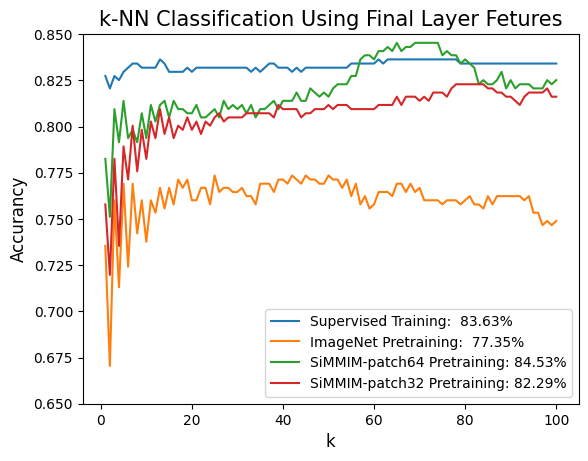

In [41]:
k = range(1,101)
plt.plot(k, Supervised_acc, label='Supervised Training: {:6.2f}%'.format(max(Supervised_acc)*100));
plt.plot(k, Pretrained_acc, label='ImageNet Pretraining: {:6.2f}%'.format(max(Pretrained_acc)*100));
plt.plot(k, SiMMIM_64_acc, label='SiMMIM-patch64 Pretraining:{:6.2f}%'.format(max(SiMMIM_64_acc)*100));
plt.plot(k, SiMMIM_32_acc, label='SiMMIM-patch32 Pretraining:{:6.2f}%'.format(max(SiMMIM_32_acc)*100));
plt.legend()
plt.title('k-NN Classification Using Final Layer Fetures',fontsize=15)
plt.xlabel('k',fontsize=12)
plt.ylabel('Accurancy',fontsize=12)
plt.ylim(0.65,0.85)
plt.show()